In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pandas as pd
from datetime import datetime
from data_handling_L1 import get_data, sliding_data

In [2]:
#Define paths
PATH_TO_L1 = '//NAS24/solo/remote/data/L1'
PATH_TO_MODEL = 'C:/Githubs/kandidat/Low_freq_files/Neural Network/model_low_freq.pt'
#Use GPU if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
def pre_process(E, V, EPOCH, start_ind, window_size=512):
    '''Preprocesses data for model.
    1. Slices data from start_ind and window_size
    2. Shapes into correct format
    3. Removes bias
    4. Normalizes each input channel with respect to max
    Returns pytorch tensor'''
    ind = start_ind
    #Slice the data for prediction
    time_processed = (np.array(EPOCH[ind:ind+window_size]) - EPOCH[ind]) / 10**9 #convert ns to s
    E1_window = np.array(E[ind:ind+window_size, 0])
    E2_window = np.array(E[ind:ind+window_size, 1])
    V_window = np.array(V[ind:ind+window_size])
    
    #Reshape the data
    data_shaped = np.array([V_window, E1_window, E2_window]).reshape(1, 3, 512)
    
    #Remove bias
    median = np.median(data_shaped, axis=2, keepdims=True)
    data_nobias = data_shaped - median
    
    #Normalize data for each channel (3)
    max_vals = np.max(np.abs(data_nobias), axis=2, keepdims=True)
    max_vals = np.where(max_vals == 0, 1, max_vals)
    data_normalized = data_nobias / max_vals
    
    #Convert into torch tensor
    data_processed = torch.from_numpy(data_normalized).float()
    
    return time_processed, data_processed

In [4]:
#Define the architecture for the neural net

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=3, out_channels=128, kernel_size=8, stride=1)
        self.bn1 = nn.BatchNorm1d(128)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=5, stride=1)
        self.bn2 = nn.BatchNorm1d(256)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.relu3 = nn.ReLU()

        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(128, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        #x = torch.tensor(x, dtype=self.conv1.weight.dtype).to(device)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.softmax(x)

        return x

In [5]:
#Create neural network
model = ConvNet()

#Load trained variables
model.load_state_dict(torch.load(PATH_TO_MODEL, map_location=device))
model.to(device)

#Set evaluation mode
model.eval()

ConvNet(
  (conv1): Conv1d(3, 128, kernel_size=(8,), stride=(1,))
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,))
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (conv3): Conv1d(256, 128, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (avgpool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=128, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)

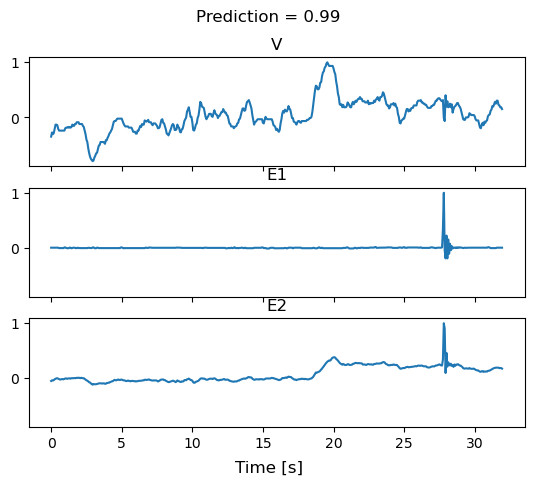

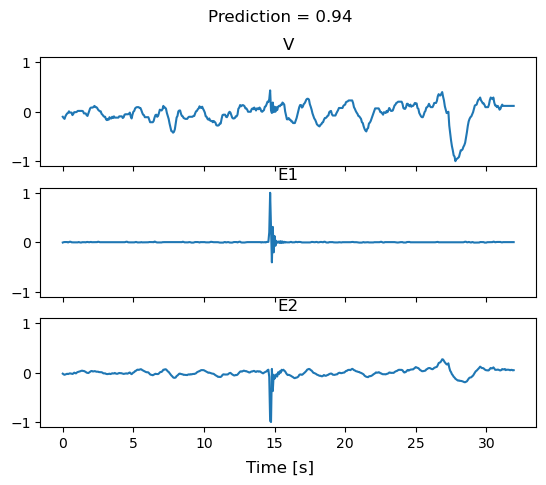

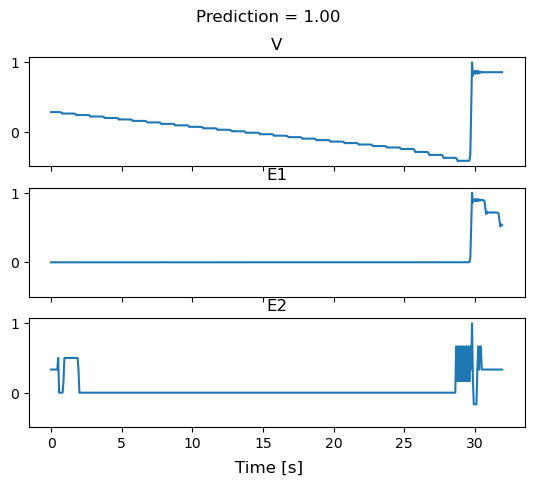

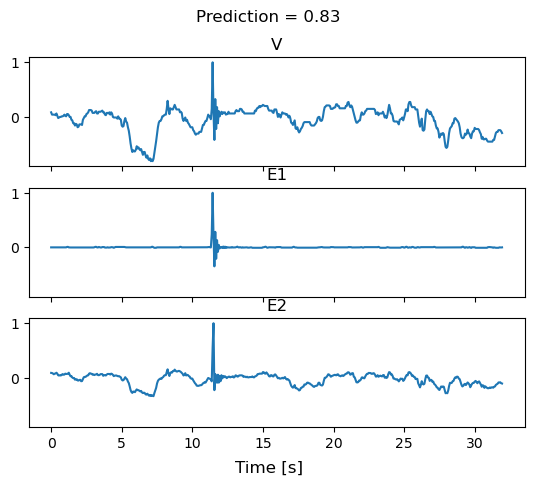

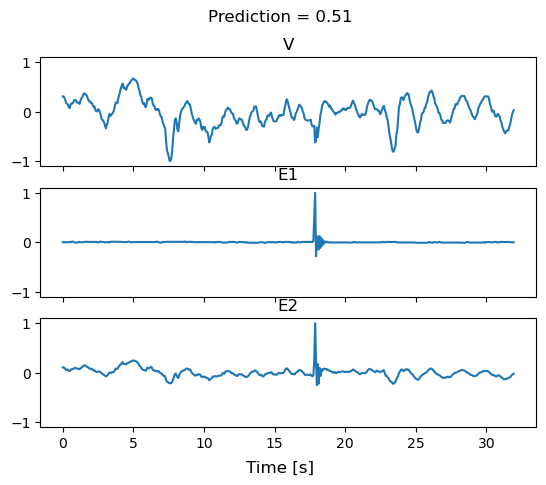

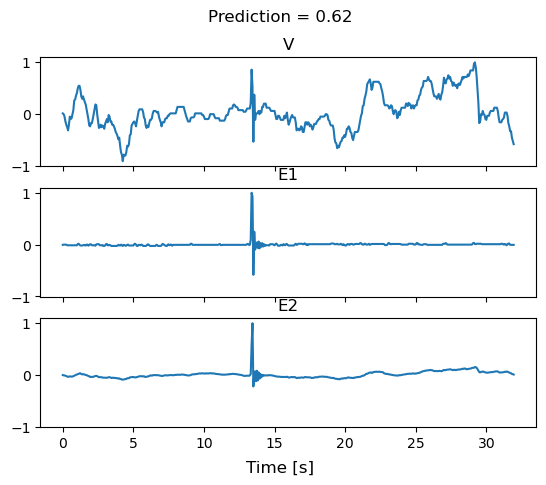

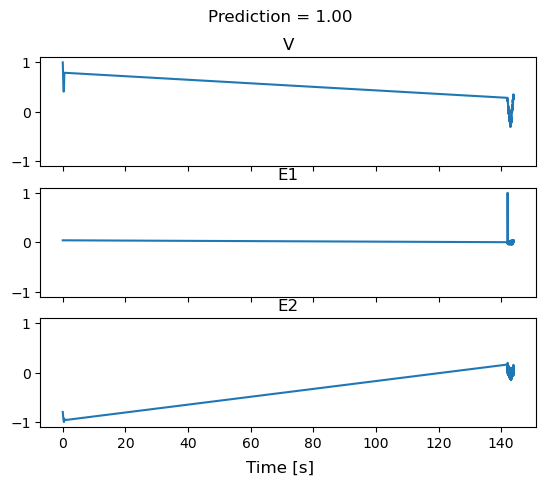

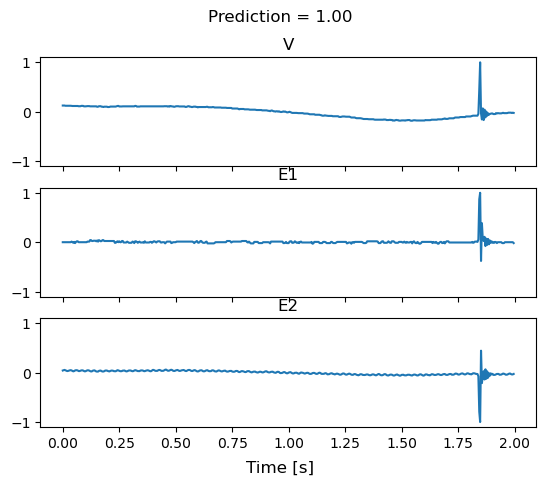

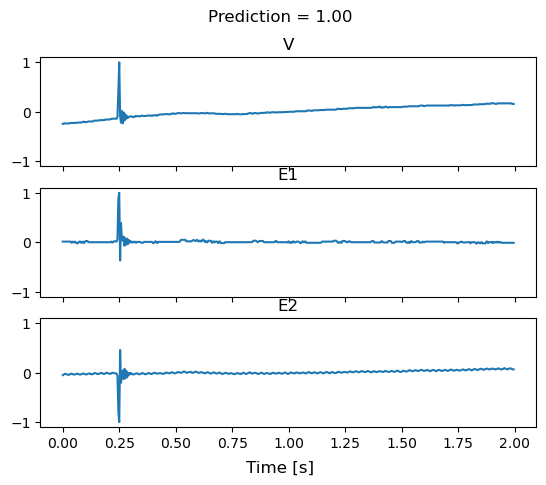

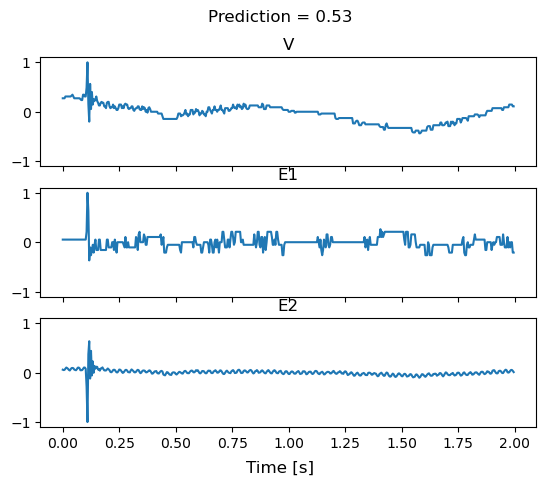

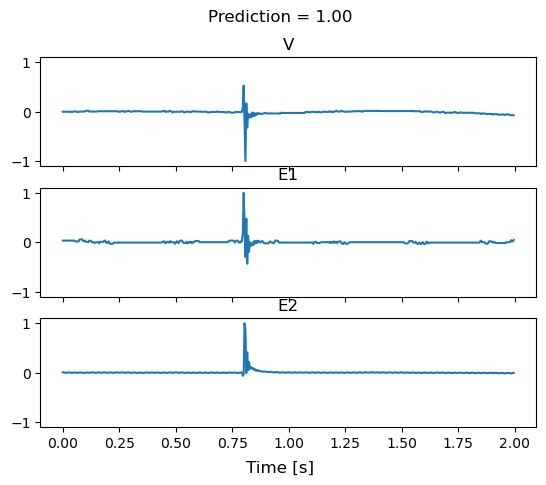

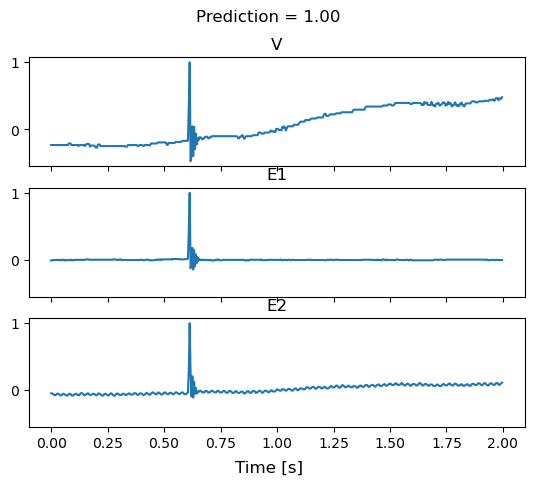

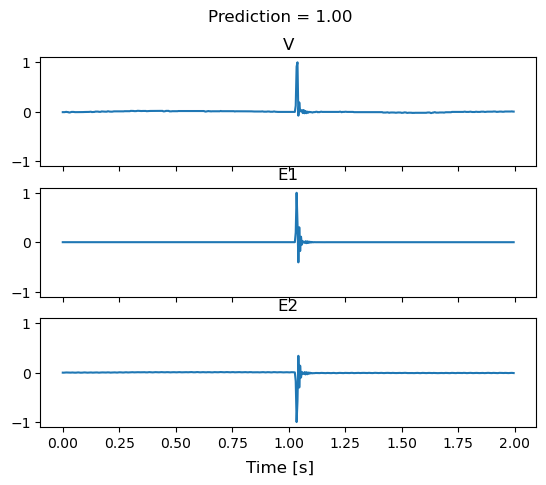

KeyboardInterrupt: 

In [14]:
window_size = 512
overlap = 0.2
start_date_str = '20230301' #20220302
end_date_str = '20230302'

start_date = datetime.strptime(start_date_str, '%Y%m%d')
end_date = datetime.strptime(end_date_str, '%Y%m%d')

plot = 'window'
%matplotlib qt
%matplotlib inline
data_dic = {}
for root, dirs, files in os.walk(PATH_TO_L1):    #iterate over L1 data
    for file in files:
        if 'rpw-lfr-surv-cwf-cdag' in file:
                date_str = file.split('_')[3]
                date = datetime.strptime(date_str, '%Y%m%d')
                if start_date <= date < end_date:
                    CURRENT_PATH = f'{PATH_TO_L1}/{file[-16:-12]}/{file[-12:-10]}/{file[-10:-8]}/{file}'
                    #Load file
                    E, V, EPOCH  = get_data(CURRENT_PATH)
                    #Slice day into windows
                    start_indices = sliding_data(E, overlap, window_size)
                    ind_dust = []
                    predictions = []
                    good_pred = []
                    recent_pos = False  
                    for ind in start_indices:
                        #Preprocess data for prediction
                        time, data = pre_process(E, V, EPOCH, ind)
                        predictions.append(model(data).cpu().detach().numpy()[0][1])
                        if predictions[-1] > 0.5 and not recent_pos:
                            recent_pos = True
                            ind_dust.append(ind)
                            good_pred.append(predictions[-1])
                            
                        if plot == 'window' and predictions[-1] > 0.5:
                            fig, axs = plt.subplots(3, 1, sharex=True, sharey=True)
                            titles = ['V', 'E1', 'E2']
                            for i in range(3):
                                axs[i].plot(time, data[0, i, :])
                                axs[i].set_title(titles[i])
                            fig.suptitle(f'Prediction = {predictions[-1]:.2f}')
                            fig.supxlabel('Time [s]')
                            plt.show()

                    print(date)
                    data_dic[date_str] = EPOCH[ind_dust]
                          
                    if plot == 'day':
                        fig, axs = plt.subplots(3, 1, sharex=True)
                        titles = ['V', 'E1', 'E2']
                        Ys = [V, E[:,0], E[:,1]]
                        for i in range(3):
                            axs[i].plot(EPOCH, Ys[i])
                            axs[i].set_title(titles[i])
                            for ind in ind_dust:
                                axs[i].axvspan(EPOCH[ind], EPOCH[ind+window_size], alpha=0.5, color='green')
                        fig.supxlabel('Time [s]')
                        fig.suptitle(date)
                        plt.show()
                    
new_df = pd.DataFrame.from_dict(data_dic, orient='index')
new_df = new_df.transpose()
new_df.to_pickle('data.pkl')